In [7]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur

Cloning into 'dip-deblur'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 52 (delta 23), reused 37 (delta 12), pack-reused 0
Unpacking objects: 100% (52/52), 719.61 KiB | 4.41 MiB/s, done.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import skimage as sk
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

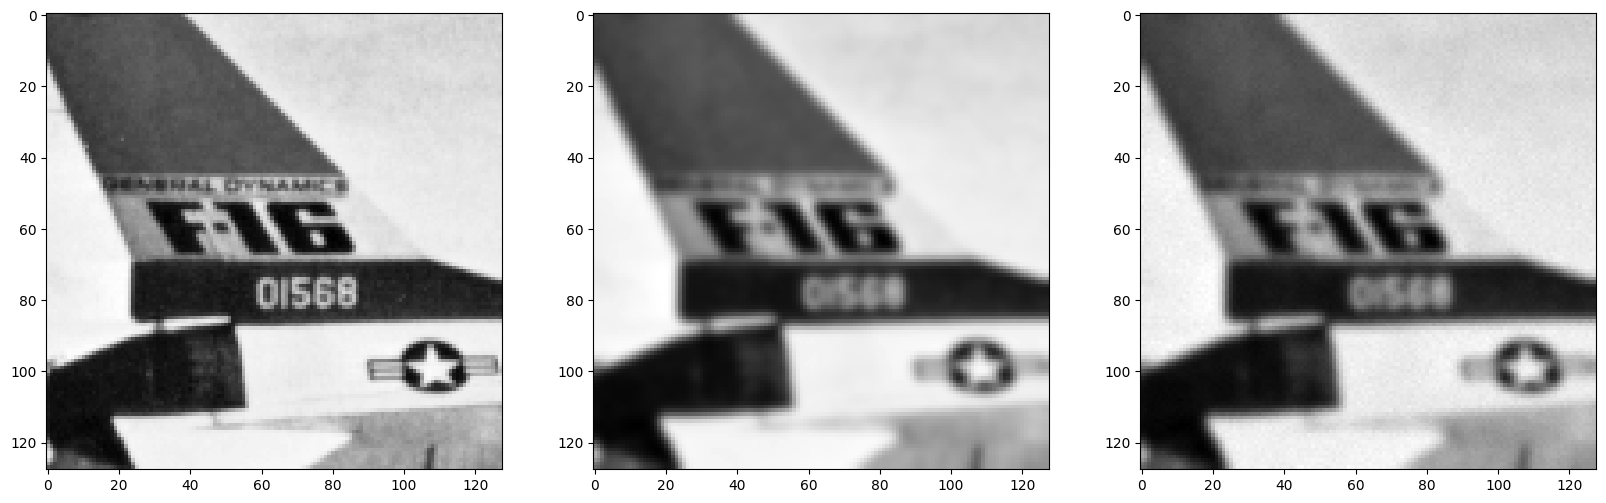

In [33]:
# Read image and create degraded version

im = read_img('data/airplane.tif', as_tensor=True).to(device)
ker = gaussian_kernel(sigma=1.2, as_tensor=True).to(device)

im_blur = blur(im, ker)
im_blur_noisy = poisson_noise(im_blur, peak=1e4)

#im_blur_noisy = read_img('data/veil128.tif', as_tensor=True).to(device)
#ker = read_img('data/veil128_psf.tif', as_tensor=True).to(device)

fig, axes = plt.subplots(1,3, figsize=(20,30))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur), cmap='gray')
axes[2].imshow(to_numpy(im_blur_noisy), cmap='gray')
plt.show()

In [37]:
nb_epoch = 2000
learning_rate = 0.01
input = (torch.rand(1,32,128,128)/10).to(device)
#input = im_blur_noisy
net_params = {
    'down_channels' : 128,
    'up_channels' : 128,
    'skip_channels' : 4,
    'depth' : 4
}

# Create network
model = Unet(in_channels=input.shape[1], out_channels=1, **net_params)
model = model.to(device)

# Create loss function and optimizer
#criterion = nn.MSELoss()
criterion = CsiszarDiv()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# Optimizing loop
model.train()
for i_epoch in range(nb_epoch):
    optimizer.zero_grad()
    im_recon = model(input)
    # enforce positivity
    im_recon = torch.max(im_recon, torch.tensor([0.001]).to(device))
    loss = criterion(blur(im_recon, ker), im_blur_noisy)
    loss.backward()
    optimizer.step()
    if (i_epoch+1) % 100 == 0:
        metric = psnr(to_numpy(im), to_numpy(im_recon))
        print(' [-] epoch {:}/{:}, loss {:.6f}, psnr {:.5f}'.format(i_epoch+1, nb_epoch, loss.item(), metric))

 [-] epoch 100/2000, loss 140.516632, psnr 18.85393
 [-] epoch 200/2000, loss 45.279182, psnr 21.82048
 [-] epoch 300/2000, loss 19.165426, psnr 23.76846
 [-] epoch 400/2000, loss 10.403330, psnr 24.93977
 [-] epoch 500/2000, loss 6.126927, psnr 25.96527
 [-] epoch 600/2000, loss 4.473249, psnr 26.61924
 [-] epoch 700/2000, loss 4.608557, psnr 26.97008
 [-] epoch 800/2000, loss 13.259680, psnr 25.88548
 [-] epoch 900/2000, loss 2.385791, psnr 28.02966
 [-] epoch 1000/2000, loss 2.867906, psnr 28.26632
 [-] epoch 1100/2000, loss 2.219333, psnr 28.58374
 [-] epoch 1200/2000, loss 7.798974, psnr 27.59714
 [-] epoch 1300/2000, loss 1.495833, psnr 29.09964
 [-] epoch 1400/2000, loss 1.340418, psnr 29.34999
 [-] epoch 1500/2000, loss 1.244352, psnr 29.53850
 [-] epoch 1600/2000, loss 1.183667, psnr 29.69302
 [-] epoch 1700/2000, loss 1.144071, psnr 29.81403
 [-] epoch 1800/2000, loss 1.168644, psnr 29.92444
 [-] epoch 1900/2000, loss 1.079231, psnr 30.02667
 [-] epoch 2000/2000, loss 1.10861

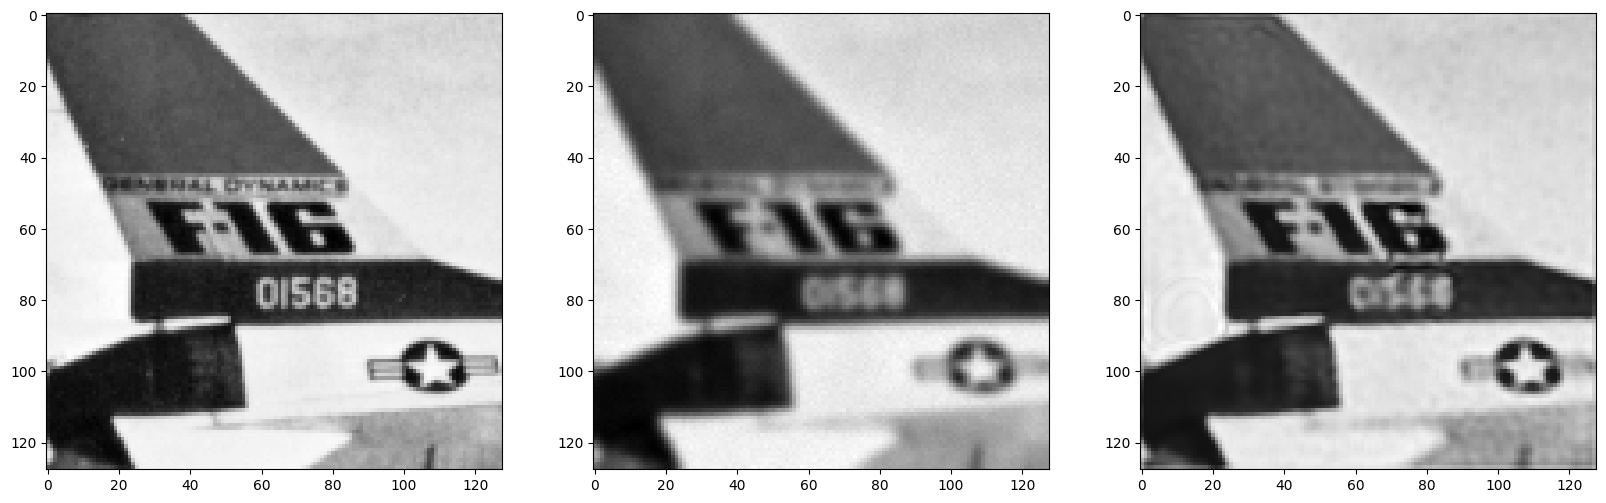

tensor(0., device='cuda:0')

In [41]:
fig, axes = plt.subplots(1,3, figsize=(20,30))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), cmap='gray')
axes[2].imshow(to_numpy(im_recon), cmap='gray')
plt.show()

In [ ]:
im_recon_blur = blur(im_recon, ker)
fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(to_numpy(im_blur_noisy), cmap='gray')
axes[1].imshow(to_numpy(im_recon_blur), cmap='gray')

In [ ]:
# For veil nebula unstretched

ref = read_img('data/veil128_stretched.tif', as_tensor=False)

fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(match_hist(to_numpy(im_blur_noisy), ref), vmin=0, vmax=1, cmap='gray')
axes[1].imshow(match_hist(to_numpy(im_recon), ref), vmin=0, vmax=1, cmap='gray')